In [25]:
from smartem import smartem,tools
from smartem.online import microscope,get_rescan_maps
from smartem.offline.train_mb_error_detector.NNtools import UNet
from smartem.segmentation import segmenter, utils
import h5py
import numpy as np
from skimage import io, measure
from pathlib import Path
import matplotlib.pyplot as plt
import pyvoi
import seaborn as sns
import pandas as pd

In [39]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
temp_dir = "/storage2/projects/smartEM/em-vis/temp/"

em2mb_model = UNet.UNet(1,2)
em2mb_path = "../../pretrained_models/em2mb_best.pth"

fast_dwt = 50
slow_dwt = 500

In [40]:
Iseg = segmenter.Segmenter(em2mb_path, segmenter_function = measure.label)
Iseg.set_model(model_class=em2mb_model)

In [41]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []

with h5py.File(hdf5_path, 'r') as f:
    for reg in f.keys():
        group = f[reg]
        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - gt_mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
        #print(f"{gt_mask.shape}, {gt_mask.dtype} {np.amin(gt_mask)}-{np.amax(gt_mask)}")

        im = group[f"{slowest_dwt}/im"][()]
        hdt_labels = Iseg.get_labels(im)

        image_names = {}

        for dwt in dwts:
            im = group[f"{dwt}/im"][()]

            im_file_path = Path(temp_dir) / f"test_{reg}_{dwt}.png"
            io.imsave(im_file_path, im)
            image_names[dwt] = str(im_file_path)

        params = {"images_ns": image_names}
        my_microscope = microscope.FakeDataMicroscope(params=params)


        params = {
            "em2mb_net": em2mb_path,
            "error_net": "../../pretrained_models/error_best.pth",
            "device": "auto",
            "pad": 0,
            "rescan_p_thres": 0.1,
            "rescan_ratio":None,#add a number to force a specific rescan ratio
            "search_step": 0.01,
            #"do_clahe": False,
        }
        get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params)

        my_smart_em = smartem.SmartEM(
            microscope=my_microscope, get_rescan_map=get_rescan_map
        )

        my_smart_em.initialize()
        
        params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
        fast_em, slow_em, rescan_map, *_ = my_smart_em.acquire(params=params)
        merged_em = fast_em.copy()
        merged_em[rescan_map] = slow_em[rescan_map]

        labels = Iseg.get_labels(merged_em)
     

        voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
        voi_hdt,_,_ = pyvoi.VI(hdt_labels.flatten(), labels.flatten())
        data_gt_vois.append(voi_gt.item())
        data_hdt_vois.append(voi_hdt.item())
        data_dwts.append(f"SmartEM: {fast_dwt}/{slow_dwt}ns")

data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
df = pd.DataFrame(data=data)

Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed function
Inverting the image as not using custom watershed functi

<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from GT (nats)'>

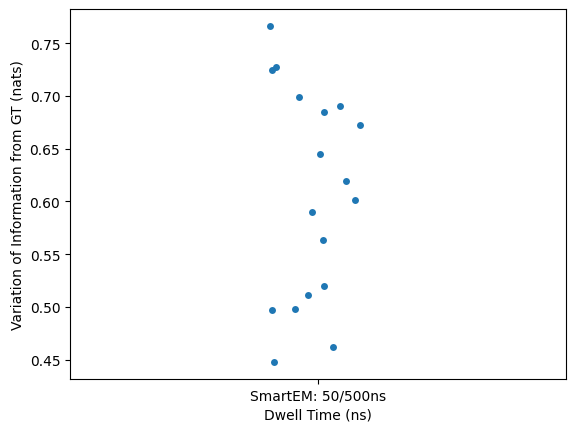

In [42]:
sns.stripplot(data=df, y="Variation of Information from GT (nats)", x="Dwell Time (ns)")